<a href="https://colab.research.google.com/github/SebasGarcia08/analytics-fundamentals-II-workshop/blob/master/taller_fundamentos_anal%C3%ADtica_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src ="https://www.icesi.edu.co/launiversidad/images/La_universidad/logosimbolos/logo_Icesi_PNG.png"/>


<center>
<h1>Final workshop</h1>


**Javier Díaz Cely**

**Universidad ICESI**

**Fundamentos de analítica II**

**Maestría en Ciencia de Datos**

**Santiago de Cali, Valle del Cauca, Colombia**

**2021-01**

</center>

# Statement

Firstly, we download the data from [UCI dataset repository](https://archive.ics.uci.edu/ml) via the wget command.

In [1]:
# Data
!wget -O data.csv -nc https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.data
# Column names
!wget -O eighthr.names -nc https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.names
# Data dictionary
!wget -O dictionary.txt -nc https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.names

File ‘data.csv’ already there; not retrieving.
File ‘eighthr.names’ already there; not retrieving.
File ‘dictionary.txt’ already there; not retrieving.


In [2]:
%%capture
!pip install wandb
!pip install tensorflow==2.3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
import os 
import random
import sklearn
from typing import List, Dict, Tuple, Any

print(f"TF version: {tf.__version__}")
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")
os.environ["WANDB_NOTEBOOK_NAME"] = "analytics-II-final-workshop"

TF version: 2.3.0
GPUs available: []


In [4]:
# Set the random seeds in order to reproduce results.
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

Data Set Information:

For a list of attributes, please refer to those two .names files. They use the following naming convention:

All the attribute start with T means the temperature measured at different time throughout the day; and those starts with WS indicate the wind speed at various time.

WSR_PK: continuous. peek wind speed -- resultant (meaning average of wind vector)

WSR_AV: continuous. average wind speed

T_PK: continuous. Peak T

T_AV: continuous. Average T

T85: continuous. T at 850 hpa level (or about 1500 m height)

RH85: continuous. Relative Humidity at 850 hpa

U85: continuous. (U wind - east-west direction wind at 850 hpa)

V85: continuous. V wind - N-S direction wind at 850

HT85: continuous. Geopotential height at 850 hpa, it is about the same as height at low altitude

T70: continuous. T at 700 hpa level (roughly 3100 m height)

RH70: continuous.

U70: continuous.

V70: continuous.

HT70: continuous.

T50: continuous. T at 500 hpa level (roughly at 5500 m height)

RH50: continuous.

U50: continuous.

V50: continuous.

HT50: continuous.

KI: continuous. K-Index [Web Link]

TT: continuous. T-Totals [Web Link]

SLP: continuous. Sea level pressure

SLP_: continuous. SLP change from previous day

Precp: continuous. -- precipitation



The following are specifications for several most important attributes that are highly valued by Texas Commission on Environmental Quality (TCEQ). More details can be found in the two relevant papers.

O 3 - Local ozone peak prediction

Upwind - Upwind ozone background level

EmFactor - Precursor emissions related factor

Tmax - Maximum temperature in degrees F

Tb - Base temperature where net ozone production begins (50 F)

SRd - Solar radiation total for the day

WSa - Wind speed near sunrise (using 09-12 UTC forecast mode)

WSp - Wind speed mid-day (using 15-21 UTC forecast mode)

In [5]:
colnames = [s.split(":")[0] for s in open("eighthr.names").readlines()[2:]] + ["ozone_day"]
colnames

['Date',
 'WSR0',
 'WSR1',
 'WSR2',
 'WSR3',
 'WSR4',
 'WSR5',
 'WSR6',
 'WSR7',
 'WSR8',
 'WSR9',
 'WSR10',
 'WSR11',
 'WSR12',
 'WSR13',
 'WSR14',
 'WSR15',
 'WSR16',
 'WSR17',
 'WSR18',
 'WSR19',
 'WSR20',
 'WSR21',
 'WSR22',
 'WSR23',
 'WSR_PK',
 'WSR_AV',
 'T0',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T10',
 'T11',
 'T12',
 'T13',
 'T14',
 'T15',
 'T16',
 'T17',
 'T18',
 'T19',
 'T20',
 'T21',
 'T22',
 'T23',
 'T_PK',
 'T_AV',
 'T85',
 'RH85',
 'U85',
 'V85',
 'HT85',
 'T70',
 'RH70',
 'U70',
 'V70',
 'HT70',
 'T50',
 'RH50',
 'U50',
 'V50',
 'HT50',
 'KI',
 'TT',
 'SLP',
 'SLP_',
 'Precp',
 'ozone_day']

Read the CSV data as a DataFrame

In [6]:
df = pd.read_csv("data.csv", names = colnames)
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone_day
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15,19.1,12.5,6.7,0.11,3.83,0.14,1612,-2.3,0.3,7.18,0.12,3178.5,-15.5,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3,2.6,3,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16,16.2,22.4,17.8,9,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.3,3172,-14.5,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22,22.1,22.2,21.3,19.8,18.6,18,18,18.2,18.3,18.4,22.2,18.7,9,0.56,0.89,10.17,1568.5,0.9,0.54,3.8,4.42,3160,-15.9,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19,19,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.9,0.89,-0.34,8.58,1546.5,3,0.77,4.17,8.11,3145.5,-16.8,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2,3,3,3.1,3.1,2.7,3,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26,25.6,24.2,22.9,21.6,20,19.5,19.1,19.1,26,21.1,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.58,0.0


Set uniformly missing data data by replacing '?'symbol with np.nan value via a lambda function.

In [7]:
df = df.apply(lambda series: series.replace("?", np.nan))
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone_day
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15,19.1,12.5,6.7,0.11,3.83,0.14,1612,-2.3,0.3,7.18,0.12,3178.5,-15.5,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3,2.6,3,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16,16.2,22.4,17.8,9,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.3,3172,-14.5,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22,22.1,22.2,21.3,19.8,18.6,18,18,18.2,18.3,18.4,22.2,18.7,9,0.56,0.89,10.17,1568.5,0.9,0.54,3.8,4.42,3160,-15.9,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19,19,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.9,0.89,-0.34,8.58,1546.5,3,0.77,4.17,8.11,3145.5,-16.8,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2,3,3,3.1,3.1,2.7,3,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26,25.6,24.2,22.9,21.6,20,19.5,19.1,19.1,26,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0


Convert features to float dtype

In [8]:
df.iloc[:,1:-1] = df.iloc[:,1:-1].astype(np.float32)
df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone_day
0,1/1/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.200000,6.100000,6.100000,6.100000,6.100000,5.600000,5.200000,5.400000,7.200000,10.600000,14.5,17.200001,18.299999,18.900000,19.100000,18.900000,18.299999,17.299999,16.799999,16.100000,15.400000,14.900000,14.800000,15.000000,19.100000,12.500000,6.7,0.11,3.83,0.14,1612.0,-2.3,0.30,7.18,0.12,3178.5,-15.500000,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.100000,15.300000,15.600000,15.600000,15.900000,16.200001,16.200001,16.200001,16.600000,17.799999,19.4,20.600000,21.200001,21.799999,22.400000,22.100000,20.799999,19.100000,18.100000,17.200001,16.500000,16.100000,16.000000,16.200001,22.400000,17.799999,9.0,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.30,3172.0,-14.500000,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.600000,16.700001,16.700001,16.799999,16.799999,16.799999,16.900000,16.900000,17.100000,17.600000,19.1,21.299999,21.799999,22.000000,22.100000,22.200001,21.299999,19.799999,18.600000,18.000000,18.000000,18.200001,18.299999,18.400000,22.200001,18.700001,9.0,0.56,0.89,10.17,1568.5,0.9,0.54,3.80,4.42,3160.0,-15.900000,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.299999,18.200001,18.299999,18.400000,18.600000,18.600000,18.500000,18.700001,18.600000,18.799999,19.0,19.000000,19.299999,19.400000,19.600000,19.200001,18.900000,18.799999,18.600000,18.500000,18.299999,18.500000,18.799999,18.900000,19.600000,18.700001,9.9,0.89,-0.34,8.58,1546.5,3.0,0.77,4.17,8.11,3145.5,-16.799999,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.799999,18.600000,18.500000,18.500000,18.600000,18.900000,19.200001,19.400000,19.799999,20.500000,21.1,21.900000,23.799999,25.100000,25.799999,26.000000,25.600000,24.200001,22.900000,21.600000,20.000000,19.500000,19.100000,19.100000,26.000000,21.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0


Cast date to date dtype, and ozone_day to integer.

In [9]:
df["Date"] = df["Date"].astype(np.datetime64)
df["ozone_day"] = df["ozone_day"].astype(int)

df.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone_day
0,1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.200000,6.100000,6.100000,6.100000,6.100000,5.600000,5.200000,5.400000,7.200000,10.600000,14.5,17.200001,18.299999,18.900000,19.100000,18.900000,18.299999,17.299999,16.799999,16.100000,15.400000,14.900000,14.800000,15.000000,19.100000,12.500000,6.7,0.11,3.83,0.14,1612.0,-2.3,0.30,7.18,0.12,3178.5,-15.500000,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0
1,1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.100000,15.300000,15.600000,15.600000,15.900000,16.200001,16.200001,16.200001,16.600000,17.799999,19.4,20.600000,21.200001,21.799999,22.400000,22.100000,20.799999,19.100000,18.100000,17.200001,16.500000,16.100000,16.000000,16.200001,22.400000,17.799999,9.0,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.30,3172.0,-14.500000,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0
2,1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.600000,16.700001,16.700001,16.799999,16.799999,16.799999,16.900000,16.900000,17.100000,17.600000,19.1,21.299999,21.799999,22.000000,22.100000,22.200001,21.299999,19.799999,18.600000,18.000000,18.000000,18.200001,18.299999,18.400000,22.200001,18.700001,9.0,0.56,0.89,10.17,1568.5,0.9,0.54,3.80,4.42,3160.0,-15.900000,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0
3,1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.299999,18.200001,18.299999,18.400000,18.600000,18.600000,18.500000,18.700001,18.600000,18.799999,19.0,19.000000,19.299999,19.400000,19.600000,19.200001,18.900000,18.799999,18.600000,18.500000,18.299999,18.500000,18.799999,18.900000,19.600000,18.700001,9.9,0.89,-0.34,8.58,1546.5,3.0,0.77,4.17,8.11,3145.5,-16.799999,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0
4,1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.799999,18.600000,18.500000,18.500000,18.600000,18.900000,19.200001,19.400000,19.799999,20.500000,21.1,21.900000,23.799999,25.100000,25.799999,26.000000,25.600000,24.200001,22.900000,21.600000,20.000000,19.500000,19.100000,19.100000,26.000000,21.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0


Set "Date" as the dataframe's index, so that the x-axis of the plots is the time.

In [10]:
df.set_index("Date", inplace=True)
df.head()

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone_day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.200000,6.100000,6.100000,6.100000,6.100000,5.600000,5.200000,5.400000,7.200000,10.600000,14.5,17.200001,18.299999,18.900000,19.100000,18.900000,18.299999,17.299999,16.799999,16.100000,15.400000,14.900000,14.800000,15.000000,19.100000,12.500000,6.7,0.11,3.83,0.14,1612.0,-2.3,0.30,7.18,0.12,3178.5,-15.500000,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.100000,15.300000,15.600000,15.600000,15.900000,16.200001,16.200001,16.200001,16.600000,17.799999,19.4,20.600000,21.200001,21.799999,22.400000,22.100000,20.799999,19.100000,18.100000,17.200001,16.500000,16.100000,16.000000,16.200001,22.400000,17.799999,9.0,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.30,3172.0,-14.500000,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.600000,16.700001,16.700001,16.799999,16.799999,16.799999,16.900000,16.900000,17.100000,17.600000,19.1,21.299999,21.799999,22.000000,22.100000,22.200001,21.299999,19.799999,18.600000,18.000000,18.000000,18.200001,18.299999,18.400000,22.200001,18.700001,9.0,0.56,0.89,10.17,1568.5,0.9,0.54,3.80,4.42,3160.0,-15.900000,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.299999,18.200001,18.299999,18.400000,18.600000,18.600000,18.500000,18.700001,18.600000,18.799999,19.0,19.000000,19.299999,19.400000,19.600000,19.200001,18.900000,18.799999,18.600000,18.500000,18.299999,18.500000,18.799999,18.900000,19.600000,18.700001,9.9,0.89,-0.34,8.58,1546.5,3.0,0.77,4.17,8.11,3145.5,-16.799999,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.799999,18.600000,18.500000,18.500000,18.600000,18.900000,19.200001,19.400000,19.799999,20.500000,21.1,21.900000,23.799999,25.100000,25.799999,26.000000,25.600000,24.200001,22.900000,21.600000,20.000000,19.500000,19.100000,19.100000,26.000000,21.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0


## Data imputation

[]

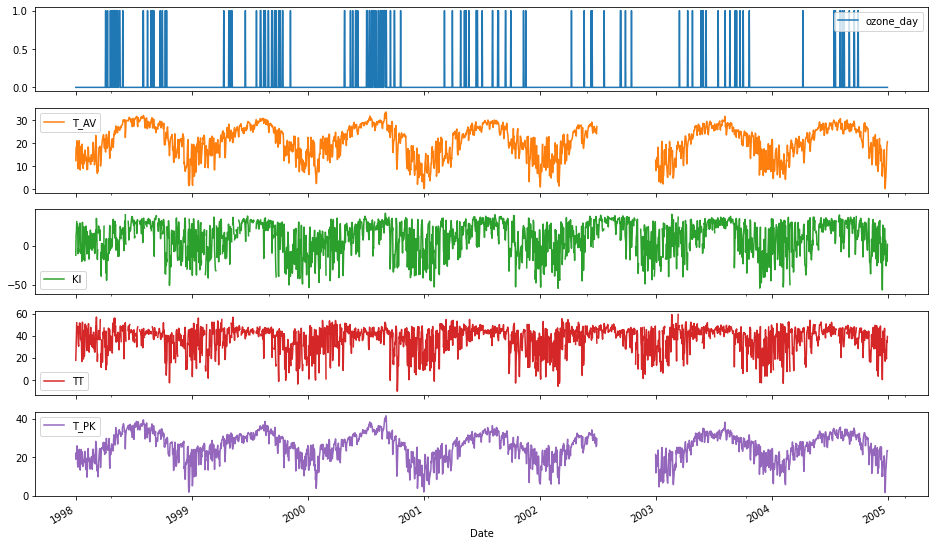

In [11]:
def impute_data(indf: pd.DataFrame, feature: str, nyears: int =4) -> pd.Series:
  """
  Impute missing observations for a feature with the mean of its 
  values in ± nyears. 

  Arguments:
    indf: a DataFrame
    feature: a column of the DataFrame, its missing values are going to tbe filled.
    nyears: number of years to consider after and before in order to impute data.

  Returns:
    A pd.Series with the missing data filled.
  """
  indf = df.copy() 

  dates_indexes_missing = indf[indf[feature].isna()][feature].index # los índices de los registros on missing values
  year = pd.Timedelta(365, unit='D')
  l = np.arange(1,nyears) # vamos a analizar los valores de la misma fecha en los años adyacentes
  nyrs = np.concatenate((l, -1*l), axis=0) # si years = 4 --> [-3, -2, -1, 1, 2, 3]

  for date in dates_indexes_missing:
    dates = [date + num_year * year for num_year in nyrs] # lista de fechas alrededor del missing
    value2replace = indf.reindex(index=dates)[feature].dropna().mean() # cálculo del promedio del mismo dia en los años alrededor
    indf.loc[date, feature] = value2replace

  return indf[feature] 

cols = [
        "ozone_day", # Target class
        "T_AV", # Target regression
        # "WSR_PK", 
        # "WSR_AV", 
        # "Precp",
        # "RH85",
        "KI",
        "TT",
        "T_PK",
]

df[cols].plot(figsize=(16,len(cols)*2), subplots=True)
plt.plot()

In [12]:
df[df[cols].isna().any(1)][cols]

,ozone_day,T_AV,KI,TT,T_PK
Date,,,,,
1998-01-05,0,21.100000,NaN,NaN,26.000000
1998-03-12,0,7.800000,NaN,NaN,9.900000
1998-03-20,0,10.100000,NaN,NaN,14.700000
1998-03-24,0,19.299999,NaN,NaN,24.900000
1998-04-01,0,17.900000,NaN,NaN,26.700001
...,...,...,...,...,...
2004-07-27,0,26.299999,NaN,NaN,31.100000
2004-07-28,0,26.900000,NaN,NaN,29.799999
2004-07-29,0,28.299999,NaN,NaN,32.000000


[]

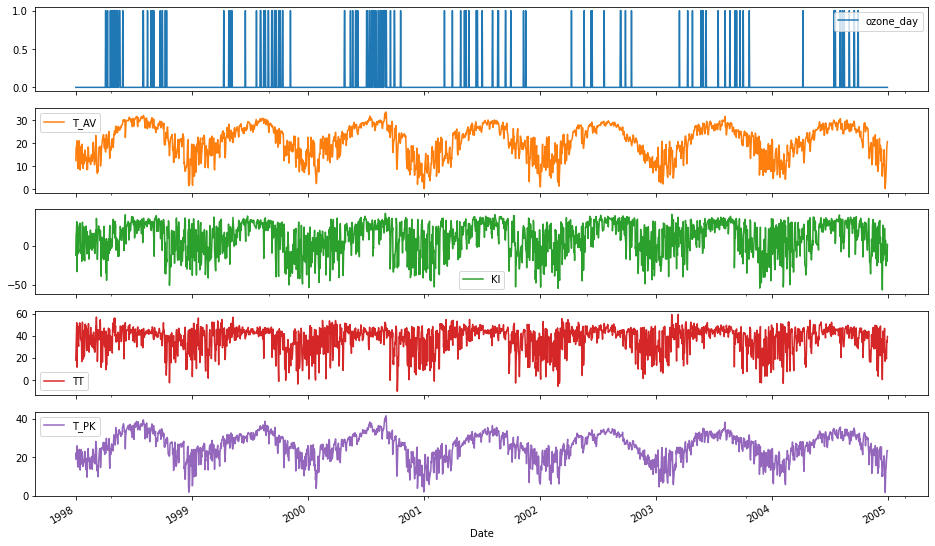

In [13]:
for col in cols[1:]:
  df[col] = impute_data(df, col)

df[cols].plot(figsize=(16,len(cols)*2), subplots=True)
plt.plot()

In [14]:
df[df[cols].isna().any(1)][cols]

,ozone_day,T_AV,KI,TT,T_PK
Date,,,,,


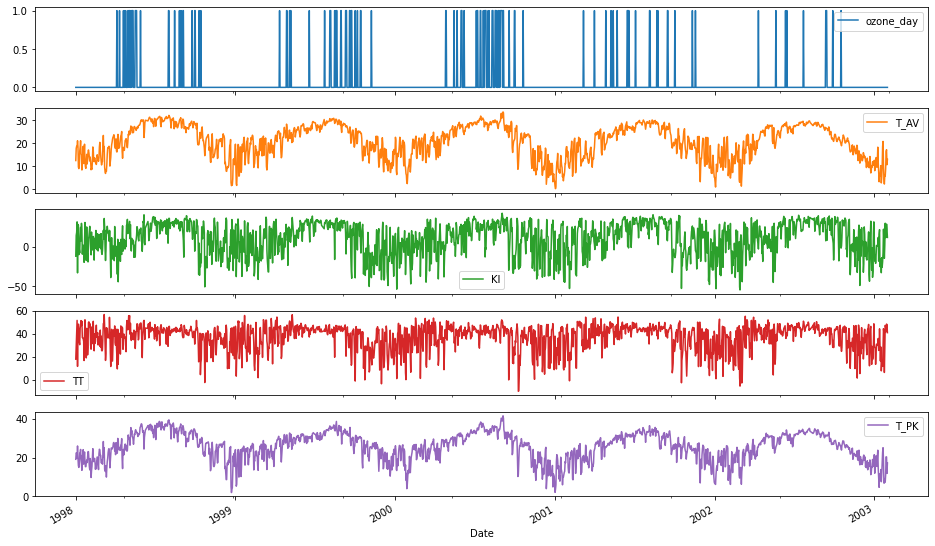

In [15]:
train_df = df[(df.index < "2003-02-01")][cols]
val_df = df[df.index >= "2003-02-01"][cols]
train_df.plot(figsize=(16,len(cols)*2), subplots=True)
plt.show()

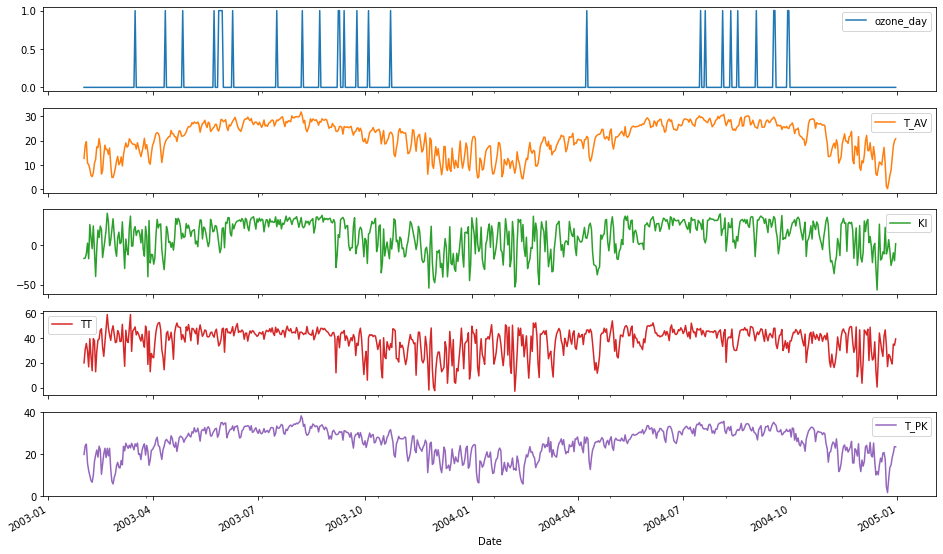

In [16]:
val_df.plot(figsize=(16,len(cols)*2), subplots=True)
plt.show()

# Data Preprocessing

## Data normalization

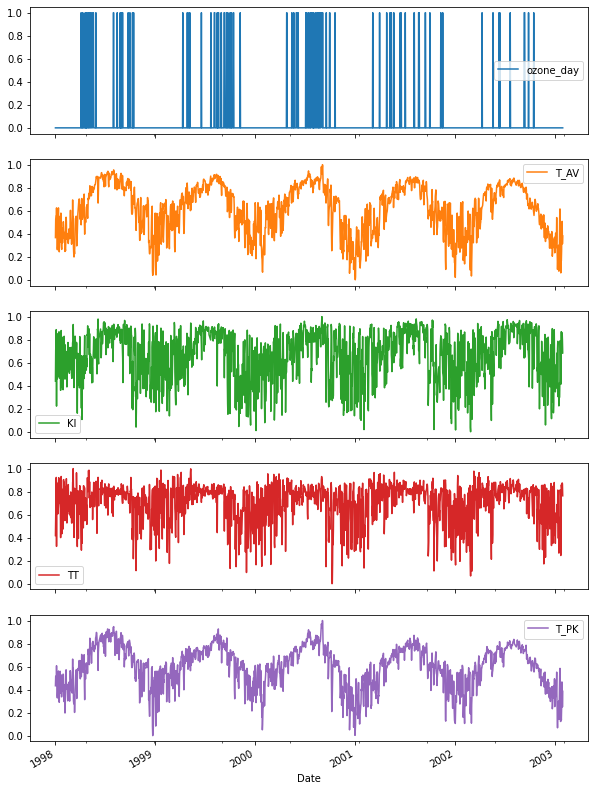

In [17]:
features = cols[1:]
cols_2_normalize = features + ["T_AV"]

def normalize(df: pd.DataFrame, cols: List[str]):
    ''' 
    Normalizes in-place the columns in df.
    
    pre: columns specified must be numbers (i.e., instances of float)
    
    Arguments:
        df: pd.DataFrame
        cols: columns of df to normalize in-place
    '''
    min_vals, max_vals = df[cols].min(), df[cols].max()
    df[cols] = (df[cols] - min_vals) / ( max_vals - min_vals )

normalize(train_df, cols_2_normalize)
normalize(val_df, cols_2_normalize)

train_df[cols].plot(subplots=True, figsize=(10,15))
plt.show()

## Data Generator

In order to feed the data into the model, we first implement a [Python generator](https://wiki.python.org/moin/Generators) that yields pairs of samples from a DataFrame sequentially. Think a Python generator as a lazy data structure that gives you the elements you want only when you request the next one. 

In [18]:
# Constant variables use to be written in UPPERCASE.
WINDOW_SIZE = 30
BATCH_SIZE = 128

def data_generator(
    df: pd.DataFrame, features: List[str], reg_label: str, 
    class_label: str, win_size: int
  ) -> Tuple[np.ndarray, np.array]:
  """
  Generates (X,y) pairs of data.

  Arguments:
    df: the DataFrame to yield samples from.

    features: a subset of df that contains the explicative variables.
    
    reg_label: a column of df, the target variable for the regression task. 
              Notice that reg_label can also be present in features.  
    
    class_label: a column of df, the target variable for the classification task.
    
    win_size: size of the window, i.e., the numner of past values used to predict 
              the next one.

  Yields:
    (X,y), the next sample in df.

    X is a np.ndarray of shape (WINDOW_SIZE, len(features)) and dtype np.float32
    y is a np.array of shape () and dtype np.float32 (becuase is the next scalar to predict). 
  """
  reg_labels = df[reg_label].values
  class_labels = df[class_label].values

  n_samples = df.shape[0]
  index = 0

  while True:
    # se retornan un registro en forma de una lista de listas [X,y]. 
    # X con los valores de los features
    # y con el valor de las dos variables dependientes, el monto de la regresión y la categoría de la clasificación
    X_train: List[np.float32] = []
    y_train: Dict[str, List[np.float32]] = {
          "reg": [],
          "class": []
    }
    
    end = index + win_size
    if end >= n_samples: # se para cuando se acaban los registros
      break
    # Get values in the [index, end) interval
    X_train = df[features].iloc[index:end,:].values  

    y_train["reg"] = reg_labels[end]
    y_train["class"] = class_labels[end]
    # Increment index so that the next time that the generator is called, 
    # the next (X,y) pair is yielded 
    index += 1
    
    yield X_train, y_train

Now that we have our general data generator; we can pass the train and validation DataFrames to the same functions and every time we iterate over the them, we will get the corresponding samples for each dataset.

In [19]:
kwargs = {
    "features": features,
    "reg_label": "T_AV",
    "class_label": "ozone_day",
    "win_size": WINDOW_SIZE
}

def train_generator():
  gen = data_generator(train_df, **kwargs)
  for X, y in gen:
    yield X, y

def val_generator():
  gen = data_generator(val_df, **kwargs)
  for X, y in gen:
    yield X, y

print(val_generator())
print(train_generator())

<generator object val_generator at 0x7efd34f1fd50>
<generator object train_generator at 0x7efd34f1fd50>


You can see that when a generator is called, what you get is an iterable object that will give you the elements sequentially only on demand. That's why we use the "next" function to get actual values.

In [20]:
x, y = next(val_generator())
print(f"X: {x.shape} \n", x)
print(f"y: reg={y['reg'].shape}, class={y['class'].shape} \n", y)

X: (30, 4) 
 [[0.39490443 0.41088852 0.3700724  0.49726775]
 [0.56369424 0.41499743 0.54384553 0.60928965]
 [0.611465   0.4714946  0.62268704 0.6311475 ]
 [0.33121017 0.6101695  0.5237329  0.38251367]
 [0.3152866  0.40677962 0.31858405 0.28688526]
 [0.25477704 0.85259366 0.6838294  0.2213115 ]
 [0.1719745  0.68412936 0.45856798 0.15573771]
 [0.15605094 0.538264   0.26709574 0.13387978]
 [0.20382163 0.8346173  0.6854384  0.22404373]
 [0.33121017 0.49203902 0.65486723 0.40710387]
 [0.38216558 0.17565487 0.25422364 0.48907104]
 [0.54458594 0.5449409  0.5237329  0.5546448 ]
 [0.53503186 0.779661   0.66613036 0.46174863]
 [0.6528662  0.6831022  0.6806114  0.6038251 ]
 [0.5509554  0.83204925 0.7932421  0.55737704]
 [0.19108279 0.788906   0.8141593  0.23770492]
 [0.23566876 0.42321518 0.57441676 0.3715847 ]
 [0.4299363  0.53312784 0.45534992 0.5027323 ]
 [0.566879   0.65125835 0.6323411  0.57650274]
 [0.5095541  0.7853106  0.80209166 0.45628414]
 [0.5095541  1.         0.99919546 0.57650274]


Now that we have our generator, we can use the TensorFlow's [tf.data API](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/data/Dataset#from_generator) to convert yielded numpy arrays into tf.Tensors and build a data pipeline. In order to provide our generator to tf.data API, we must specify both the shapes and dtpyes of the values that it yields.

In [21]:
# This is deprecatd in tf 2.5, if you're running this on that version, try with:
"""
output_signature = ( 
    tf.TensorSpec(shape=(WINDOW_SIZE, len(features),), dtype=tf.float32), 
    {
        "reg" : tf.TensorSpec(shape=(), dtype=tf.float32),
        "class" : tf.TensorSpec(shape=(), dtype=tf.int32)
    }
)
"""

output_types = (
    tf.float32, # Dtype of the X matrix 
    {
        "reg": tf.float32, # Dtype of the regression label
        "class": tf.int32  # Dtype of the classification label
    }
)

output_shapes = (
    (WINDOW_SIZE, len(features),), # Dtype of the X matrix 
    {
        "reg": (), # Shape of the regression label
        "class": ()  # Shape of the classification label
    }
)

def get_generator(gen) -> tf.data.Dataset:
  """
  Converts a Python generator to a tf.Dataset.
  """
  dataset = tf.data.Dataset.from_generator(
    gen, output_types=output_types, output_shapes=output_shapes
  )
  # Pre-load data in order to increse performance 
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # This is tf.data.AUTOTUNE in tf>=2.4
  # Repeat the dataset wehen all elements are already yielded
  dataset = dataset.repeat() 
  # Shuffle the data to to eliminate order bias
  dataset = dataset.shuffle(buffer_size = 1000)
  # Get batched tensors. i.e. 
  # X will be a tensor of shape (BATCH_SIZE, WINDOWS_SIZE, N_FEATURES)
  # and both y["reg"] and y ["class"] will be of shape (BATCH_SIZE,)
  dataset = dataset.batch(BATCH_SIZE)
  return dataset 

train_gen = get_generator(train_generator)
val_gen = get_generator(val_generator)

x,y = next(iter(train_gen))
print(f"Shapes")
print(f"X (BATCH_SIZE, WINDOWS_SIZE, N_FEATURES): {x.shape}")
print(f"y['reg'] (BATCH_SIZE,): {y['reg'].shape}")
print(f"y['class'] (BATCH_SIZE,): {y['class'].shape}")
print()

print("First batches:")
print("X:")
print(x[0])
print()

print('y["reg"]:')
print(y["reg"][0])
print()

print('y["class"]:')
print(y["class"][0])

Shapes
X (BATCH_SIZE, WINDOWS_SIZE, N_FEATURES): (128, 30, 4)
y['reg'] (BATCH_SIZE,): (128,)
y['class'] (BATCH_SIZE,): (128,)

First batches:
X:
tf.Tensor(
[[0.77777785 0.9068805  0.8192681  0.6599497 ]
 [0.8618619  0.9627523  0.8349515  0.76574314]
 [0.8738739  0.8836006  0.845407   0.7682621 ]
 [0.8738739  0.8375582  0.8595968  0.78085655]
 [0.8618619  0.69943094 0.7632562  0.77329975]
 [0.8618619  0.88791174 0.8048296  0.75818646]
 [0.85285294 0.75737196 0.76176256 0.75818646]
 [0.82282287 0.90791523 0.80507845 0.745592  ]
 [0.7987988  0.9053286  0.8170276  0.7153653 ]
 [0.7567568  0.9146404  0.82748324 0.69773304]
 [0.82282287 0.8923953  0.8401794  0.78085655]
 [0.8318319  0.91257113 0.81628084 0.76574314]
 [0.7957958  0.8882566  0.7976102  0.69269526]
 [0.8108108  0.89808595 0.8349515  0.73047864]
 [0.80780786 0.8768754  0.8297238  0.7355164 ]
 [0.7957958  0.89187795 0.84391344 0.7103275 ]
 [0.7357358  0.8727367  0.78416735 0.6801008 ]
 [0.8288289  0.8923953  0.7737118  0.78085655

# Baseline

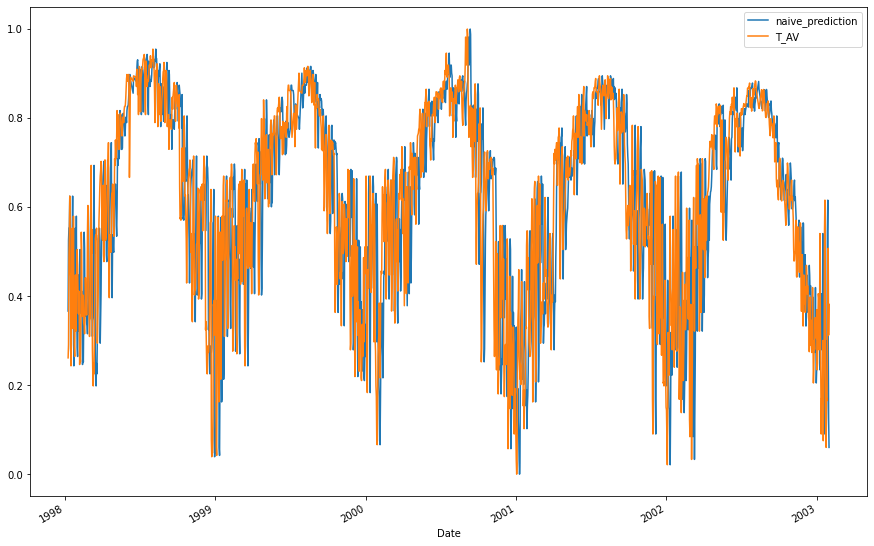

In [22]:
import datetime

def naive_forecasting(df, window):
  naive_prediction = df[["T_AV"]].shift(1, freq=datetime.timedelta(days=window))
  naive_prediction.columns = ["naive_prediction"]

  naive = df[["T_AV"]].merge(naive_prediction, 
                          how="outer", left_index=True, 
                          right_index=True)[['naive_prediction',"T_AV"]].iloc[window:-window,:]
  naive = naive.dropna()
  return naive

naive = naive_forecasting(train_df, 7)
naive.plot(figsize=(15,10))
plt.show()

In [53]:
from tensorflow.keras.metrics import MSE, MAPE

@tf.function
def r_2(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true),axis=0) * 100

def get_preds(naive):
  y_true = naive["T_AV"].values
  y_pred = naive["naive_prediction"].values
  return y_true, y_pred 

def evaluate(y_true, y_pred):
  print(f"MAPE {MAPE(y_true, y_pred)}")
  print(f"r squared {r_2(y_true, y_pred)}")
  print(f"MSE {MSE(y_true, y_pred)}")

In [54]:
train_naive = naive_forecasting(train_df, 7)
preds = get_preds(train_naive)
evaluate(*preds)

MAPE 167971.234375
r squared 0.5157150030136108
MSE 0.021786751225590706


In [55]:
val_naive = naive_forecasting(val_df, 7)
preds = get_preds(val_naive)
evaluate(*preds)

MAPE 502388.46875
r squared 0.49576884508132935
MSE 0.022547287866473198


# Training

In [ ]:
!wandb login

wandb: Currently logged in as: sebastian-garcia-acosta (use `wandb login --relogin` to force relogin)


In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Conv1D, Dense, Input, Dropout
from tensorflow.keras.metrics import MAPE, AUC
import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score

def AUC_ROC(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metrics = {
    "reg": [r_2, MAPE],
    "class": [AUC(name="auc"), f1],
}

# Initialize wandb with your project name
run = wandb.init(project='analytics-II-final-workshop',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 1000,
                     "batch_size": BATCH_SIZE,
                     'patience': 20,
                     "losses": {
                         "reg":"mse",
                         "class": "binary_crossentropy",
                     },
                     'metrics': metrics,
                     'window_size': WINDOW_SIZE,
                     "architecture": "Conv1D",
                     "dataset-link": "https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection",
                     'dataset': 'Ozone Level Detection',
                     'group': 'jetson-nano',
                     'name': 'nano-fixed',
                 })

config = wandb.config

In [ ]:
tf.keras.backend.clear_session()
tf.debugging.set_log_device_placement(True)

input = Input(shape= (WINDOW_SIZE, len(features)), name="input")
X = Conv1D(filters=64, kernel_size=5, activation='relu', name="conv1d_1")(input)
X = Conv1D(filters=32, kernel_size=3, activation='relu', name="conv1d_2")(X)
X = Flatten()(X)
X = Dropout(0.2)(X)
X = Dense(50, activation="relu", name="dense_1")(X)
output_reg = Dense(1, activation="linear", name="reg")(X)
output_class = Dense(1, activation="sigmoid", name="class")(X)

model = Model(inputs = [input], outputs={
    "reg": output_reg,
    "class": output_class
})

optimizer = tf.keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer='adam', loss=config.losses, metrics=metrics)

x,y = next(iter(train_gen))
print(x.shape)
print(y["reg"].shape)
preds = model.predict(x)
preds["reg"].shape

(128, 30, 4)
(128,)


(128, 1)

In [ ]:
plot_model(model, show_shapes=True, show_dtype=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Train

In [ ]:
tf.keras.backend.set_floatx("float32")

n_samples_train = train_df.shape[0]
n_samples_val = val_df.shape[0]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=config.patience,
                                                  restore_best_weights=True,
                                                  mode='min')

wand_callback = WandbCallback()

In [ ]:
history = model.fit(
    train_gen, 
    epochs=1000, 
    validation_data = val_gen,
    steps_per_epoch= n_samples_train // BATCH_SIZE,
    validation_steps =  n_samples_val // BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, wand_callback]
)

Epoch 1/1000
14/14 [==============================] - 30s 1s/step - loss: 0.7410 - class_loss: 0.6302 - reg_loss: 0.1107 - class_auc: 0.5094 - class_f1: 0.0674 - reg_r_2: -1.4199 - reg_mean_absolute_percentage_error: 299919.5075 - val_loss: 0.2394 - val_class_loss: 0.2175 - val_reg_loss: 0.0219 - val_class_auc: 0.3349 - val_class_f1: 0.0000e+00 - val_reg_r_2: 0.4554 - val_reg_mean_absolute_percentage_error: 24.5392
Epoch 2/1000
14/14 [==============================] - 16s 1s/step - loss: 0.3330 - class_loss: 0.3033 - reg_loss: 0.0297 - class_auc: 0.3204 - class_f1: 0.0000e+00 - reg_r_2: 0.2870 - reg_mean_absolute_percentage_error: 32.6267 - val_loss: 0.2549 - val_class_loss: 0.2363 - val_reg_loss: 0.0186 - val_class_auc: 0.2376 - val_class_f1: 0.0000e+00 - val_reg_r_2: 0.5375 - val_reg_mean_absolute_percentage_error: 23.4697
Epoch 3/1000
14/14 [==============================] - 16s 1s/step - loss: 0.3014 - class_loss: 0.2750 - reg_loss: 0.0263 - class_auc: 0.3605 - class_f1: 0.0000e+00

In [ ]:
model.evaluate(val_gen, steps= (n_samples_val // BATCH_SIZE) )

5/5 [==============================] - 8s 618ms/step - loss: 0.1900 - class_loss: 0.1776 - reg_loss: 0.0124 - class_auc: 0.7122 - class_f1: 0.0000e+00 - reg_r_2: 0.6816 - reg_mean_absolute_percentage_error: 16.8260


[0.1899890899658203,
 0.17755194008350372,
 0.012437157332897186,
 0.7121848464012146,
 0.0,
 0.68163001537323,
 16.826040267944336]

In [ ]:
inputs = [] 
ys = {
    "reg": [],
    "class": []
}

for x,y in val_generator():
  inputs.append(x)
  ys["reg"].append(y["reg"])
  ys["class"].append(y["class"])

ys["reg"] = np.array(ys["reg"]).flatten()
ys["class"] = np.array(ys["class"])

inputs = np.array(inputs)
preds = model.predict(inputs)

<AxesSubplot:>

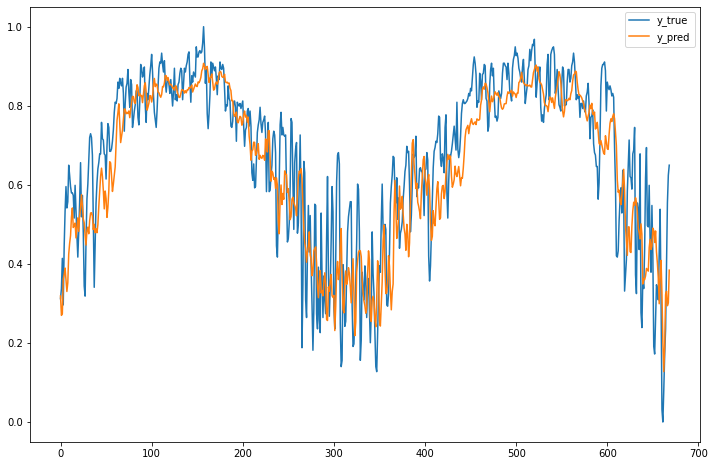

In [ ]:
pd.DataFrame(data={"y_true": ys["reg"], "y_pred": preds["reg"].flatten()}).plot(figsize=(12,8))

In [ ]:
evaluate(ys["reg"], preds["reg"].flatten())

MAPE 304366.46875
r squared 0.6937078237533569
MSE 0.013009213842451572


No handles with labels found to put in legend.


0.6966594827586207


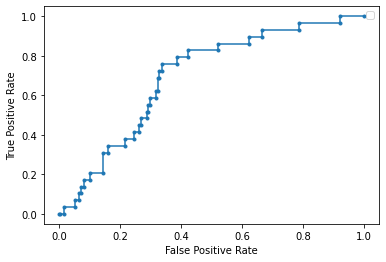

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

testy, probs = ys["class"], preds["class"].ravel()
fpr, tpr, _ = roc_curve(testy, probs)
auc_score = roc_auc_score(testy, probs)

print(auc_score)
plt.plot(fpr, tpr, marker='.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()